In [1]:
from keras.optimizers import SGD
from convnetskeras.convnets import preprocess_image_batch, convnet
from convnetskeras.imagenet_tool import synset_to_dfs_ids
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pickle
from keras.models import load_model
from keras.models import Sequential
from keras.models import Model
from keras.utils.layer_utils import layer_from_config
from keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img,img_to_array
import itertools
from convnetskeras.customlayers import Softmax4D
import gc
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import model_from_json
from keras.applications.inception_v3 import InceptionV3

Using Theano backend.


In [4]:
model = InceptionV3()

In [5]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 299, 299)   0                                            
____________________________________________________________________________________________________
convolution2d_95 (Convolution2D) (None, 32, 149, 149)  896         input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_95 (BatchNorm (None, 32, 149, 149)  128         convolution2d_95[0][0]           
____________________________________________________________________________________________________
convolution2d_96 (Convolution2D) (None, 32, 147, 147)  9248        batchnormalization_95[0][0]      
___________________________________________________________________________________________

In [176]:
def from_config(layer, config_dic):
    config_correct = {}
    config_correct['class_name'] = type(layer)
    config_correct['config'] = config_dic
    #print(config_correct)
    return layer_from_config(config_correct)

def add_to_model(model, layer):
    #print(layer.output_shape)
    new_layer = from_config(layer, layer.get_config())
    model.add(new_layer)
    #print(new_layer.get_config())
    if layer.get_weights() is not None:
        new_layer.set_weights(layer.get_weights())

def layer_type(layer):
    return str(layer)[10:].split(" ")[0].split(".")[-1]

def detect_configuration(model):
    # must return the configuration and the number of the first pooling layer
    
    # Names (types) of layers from end to beggining
    inverted_list_layers = [layer_type(layer) for layer in model.layers[::-1]]
    
    layer1 = None
    layer2 = None 
    
    i = len(model.layers)
    
    for layer in inverted_list_layers:
        i -= 1
        if layer2 is None:
            if layer == "GlobalAveragePooling2D" or layer == "GlobalMaxPooling2D":
                layer2 = layer

            elif layer == "Flatten":
                return "local pooling - flatten", i
            
        else:
            layer1 = layer
            break
            
    if layer1 == "MaxPooling2D" and layer2 == "GlobalMaxPooling2D":
        return "local pooling - global pooling (same type)", i
    elif layer1 == "AveragePooling2D" and layer2 == "GlobalAveragePooling2D":
        return "local pooling - global pooling (same type)", i
    
    elif layer1 == "MaxPooling2D" and layer2 == "GlobalAveragePooling2D":
        return "local pooling - global pooling (different type)", i+1
    elif layer1 == "AveragePooling2D" and layer2 == "GlobalMaxPooling2D":
        return "local pooling - global pooling (different type)", i+1
    
    else:
        return "global pooling", i
    
def insert_weights(layer, new_layer):
    W,b = layer.get_weights()
    print(W.shape)
    n_filter,previous_filter,ax1,ax2 = new_layer.get_weights()[0].shape
    new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
    new_W = new_W.transpose((3,0,1,2))
    new_W = new_W[:,:,::-1,::-1]
    new_layer.set_weights([new_W,b])
    
def copy_last_layers(model, new_model, begin):
    
    i=begin
    
    for layer in model.layers[begin:]:
        if layer_type(layer) == "Dense":
                
            add_reshaped_layer(layer, new_model, 1)
            
        elif layer_type(layer) == "Dropout":
            print("ngrezibgruzeig")
            pass
                
        elif layer_type(layer) == "Activation" and i == len(model.layers)-1:
            break
               
        else:
            print(i)
            print(len(model.layers))
            print(layer_type(layer))
            add_to_model(new_model, layer)
        i+=1
    
    new_model.add(Softmax4D(axis=1,name="softmax"))
    
                
def add_reshaped_layer(layer, new_model, size):

    conf = layer.get_config()
    
    new_layer = Convolution2D(conf["output_dim"],size,size,activation=conf["activation"], name=conf['name'])
         
        
    new_model.add(new_layer)
    # We transfer the weights:
    insert_weights(layer, new_layer)
    

def to_heatmap_sequential(model, size=None, increased_resolution=False, sequential=False, delete = False):
    
    # First, we need to find which layers need special attention. 
    # We do that by examining the last layers and stop once we see a pool layer. (what if 2 pooling layers?)
    # eg: averagePool -> globalPool?
    # This is for later. Right now, we need a simple heatmap.
    
    # there are four configurations possible:
    # global pooling
    # local pooling - flatten
    # local pooling - global pooling (same type)
    # local pooling - global pooling (different type)
    
    model_type, index = detect_configuration(model)
    
    # We reproduce the beggining of the network.
    new_model = Sequential()
    
    # The first layer is kind of special:
    dic = model.layers[0].get_config()
    dic["batch_input_shape"] = (None, 3, None, None)
    
    new_layer = from_config(model.layers[0], dic)
    old_weights = new_layer.get_weights()
    
    #new_layer.set_weights(model.layers[0].get_weights())
    
    new_model.add(new_layer)
    
    
    for layer in model.layers[1:index]:
        add_to_model(new_model, layer)
        
    if model_type == "global pooling":
        copy_last_layers(model, new_model, index+1)
              
    elif model_type == "local pooling - flatten":
        
        add_reshaped_layer(model.layers[index+1], new_model, size)
        
        copy_last_layers(model, new_model, index+2)
        
        
    elif model_type == "local pooling - global pooling (same type)":
        copy_last_layers(model, new_model, index+2)
    elif model_type == "local pooling - global pooling (different type)":
        copy_last_layers(model, new_model, index+1)
    else:
        raise IndexError("no type for model: " + str(model_type))
        
    # check
    for i in range(index):
        w1 = new_model.layers[i].get_weights()
        w2 = model.layers[i].get_weights()
        try:
            if np.sum(w1[0]- w2[0]) !=0:
                print("bug at 1 layer " + str(i))
                print(w1[0]-w2[0])
                assert False
            
            if np.sum(w1[1]- w2[1]) != 0:
                print("bug at 2 layer " + str(i))
                print(w1[1]-w2[1])
                assert False
        except IndexError:
            pass   
    
    if delete:
        del(model)
        gc.collect()
    
    return new_model
    

In [6]:
def from_config(layer, config_dic):
    config_correct = {}
    config_correct['class_name'] = type(layer)
    config_correct['config'] = config_dic
    #print(config_correct)
    return layer_from_config(config_correct)

def add_to_model(x, layer):
    #print(layer.output_shape)
    new_layer = from_config(layer, layer.get_config())
    x = new_layer(x)
    #print(new_layer.get_config())
    if layer.get_weights() is not None:
        new_layer.set_weights(layer.get_weights())
    return x

def layer_type(layer):
    return str(layer)[10:].split(" ")[0].split(".")[-1]

def detect_configuration(model):
    # must return the configuration and the number of the first pooling layer
    
    # Names (types) of layers from end to beggining
    inverted_list_layers = [layer_type(layer) for layer in model.layers[::-1]]
    
    layer1 = None
    layer2 = None 
    
    i = len(model.layers)
    
    for layer in inverted_list_layers:
        i -= 1
        if layer2 is None:
            if layer == "GlobalAveragePooling2D" or layer == "GlobalMaxPooling2D":
                layer2 = layer

            elif layer == "Flatten":
                return "local pooling - flatten", i
            
        else:
            layer1 = layer
            break
            
    if layer1 == "MaxPooling2D" and layer2 == "GlobalMaxPooling2D":
        return "local pooling - global pooling (same type)", i
    elif layer1 == "AveragePooling2D" and layer2 == "GlobalAveragePooling2D":
        return "local pooling - global pooling (same type)", i
    
    elif layer1 == "MaxPooling2D" and layer2 == "GlobalAveragePooling2D":
        return "local pooling - global pooling (different type)", i+1
    elif layer1 == "AveragePooling2D" and layer2 == "GlobalMaxPooling2D":
        return "local pooling - global pooling (different type)", i+1
    
    else:
        return "global pooling", i
    
def insert_weights(layer, new_layer):
    W,b = layer.get_weights()
    print(W.shape)
    n_filter,previous_filter,ax1,ax2 = new_layer.get_weights()[0].shape
    print(new_layer.get_weights()[0].shape)
    new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
    new_W = new_W.transpose((3,0,1,2))
    new_W = new_W[:,:,::-1,::-1]
    new_layer.set_weights([new_W,b])
    
def copy_last_layers(model, begin,x):
    
    i=begin
    
    for layer in model.layers[begin:]:
        if layer_type(layer) == "Dense":
            print(layer.name)
            
            if i == len(model.layers)-1:
                x = add_reshaped_layer(layer, 1,x, no_activation=True)
            else:
                x = add_reshaped_layer(layer, 1,x)
            
        elif layer_type(layer) == "Dropout":
            print("ngrezibgruzeig")
            pass
                
        elif layer_type(layer) == "Activation" and i == len(model.layers)-1:
            break
               
        else:
            print(i)
            print(len(model.layers))
            print(layer_type(layer))
            x = add_to_model(x, layer)
        i+=1
    
    x = Softmax4D(axis=1,name="softmax")(x)
    return x
    
                
def add_reshaped_layer(layer, size, x, no_activation=False):

    conf = layer.get_config()
    
    if no_activation:
        activation="linear"
    else:
        activation=conf["activation"]
    
    new_layer = Convolution2D(conf["output_dim"],size,size, activation=activation, name=conf['name'])
         
        
    x= new_layer(x)
    # We transfer the weights:
    insert_weights(layer, new_layer)
    return x
    

def to_heatmap_sequential(model, size=None, increased_resolution=False, sequential=False, delete = False):
    
    # there are four configurations possible:
    # global pooling
    # local pooling - flatten
    # local pooling - global pooling (same type)
    # local pooling - global pooling (different type)
    
    model_type, index = detect_configuration(model)
    
    #new_layer.set_weights(model.layers[0].get_weights())
    img_input = Input(shape=(3,None,None))
   
    # Inchanged part:
    middle_model = Model(input=model.layers[1].input, output=model.layers[index-1].output)
    
    x = middle_model(img_input)
        
    if model_type == "global pooling":
        x = copy_last_layers(model, index+1,x)
              
    elif model_type == "local pooling - flatten":
        
        if index+1 != len(model.layers)-1:
            x = add_reshaped_layer(model.layers[index+1], size,x)
        else:
            x = add_reshaped_layer(model.layers[index+1], size,x,no_activation=True)
        print(index)
        x = copy_last_layers(model, index+2,x)
        
        
    elif model_type == "local pooling - global pooling (same type)":
        x = copy_last_layers(model, index+2,x)
    elif model_type == "local pooling - global pooling (different type)":
        x= copy_last_layers(model, index+1,x)
    else:
        raise IndexError("no type for model: " + str(model_type))
        
    
    
    if delete:
        del(model)
        gc.collect()
    
    return Model(img_input, x)
    

In [8]:
model = ResNet50()

In [12]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 2048, None, No 23587712    input_1[0][0]                    
____________________________________________________________________________________________________
dense_4 (Convolution2D)          (None, 256, None, Non 524544      model_1[1][0]                    
____________________________________________________________________________________________________
dense_5 (Convolution2D)          (None, 128, None, Non 32896       dense_4[0][0]                    
___________________________________________________________________________________________

In [49]:
model = VGG19()

In [2]:
# load json and create model
json_file = open('model_2c_10e_R50_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_2c_10e_R50_1.h5")
print("Loaded model from disk")

Loaded model from disk


In [8]:
new_model = to_heatmap_sequential(model, 1, delete=False)

(2048, 1000)
(1000, 2048, 1, 1)
218


In [8]:
model=new_model

In [22]:
model.layers[-4].get_config()

{'W_constraint': None,
 'W_regularizer': None,
 'activation': 'relu',
 'activity_regularizer': None,
 'b_constraint': None,
 'b_regularizer': None,
 'bias': True,
 'init': 'glorot_uniform',
 'input_dim': None,
 'name': 'dense_2',
 'output_dim': 4096,
 'trainable': True}

In [35]:
str(model.layers[-1])[10:].split(" ")[0].split(".")[-1]

'Activation'

In [72]:
model.layers[-31].get_weights()[0].shape

(256, 256, 3, 3)

In [48]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_33 (ZeroPadding2D) (None, 3, 226, 226)   0           zeropadding2d_input_3[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 224, 224)  1792        zeropadding2d_33[0][0]           
____________________________________________________________________________________________________
zeropadding2d_34 (ZeroPadding2D) (None, 64, 226, 226)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, 224, 224)  36928       zeropadding2d_34[0][0]           
___________________________________________________________________________________________

In [ ]:
def to_heatmap_functional(model, resolution_x2=False, sequential=False):
    

In [2]:
def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False

In [3]:
import os
from fnmatch import fnmatch

l = []

root = './train/'
pattern = "*.jpg"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            l.append(os.path.join(path, name))

In [4]:
l[0]

'./train/ALB\\img_00003.jpg'

In [5]:
s = 7
dest = [ string[:s] + "_heatmap" + string[s:] for string in l]
dest[0]

'./train_heatmap/ALB\\img_00003.jpg'

In [6]:
dest_pickle = [ string[:s] + "_pickle" + string[s:] for string in l]

In [7]:
def get_heatmap(path,model):
        
    im = preprocess_image_batch([path], color_mode="bgr")

    out = model.predict(im)

    s = "n02512053"
    ids = synset_to_dfs_ids(s)
    heatmap = out[0,ids].sum(axis=0)
    return heatmap


def save_heatmaps(model,l,dest_pickle, dest):
    for i in tq(range(len(l))):

        heatmap = get_heatmap(l[i], model)

        im = preprocess_image_batch([l[i]], color_mode="bgr")

        plt.imsave(dest[i],heatmap)
        
        with open(dest_pickle[i],"wb") as f:
            pickle.dump(heatmap, f)
        

In [3]:
pb = tq(total=47)
old_model = convnet('vgg_19',weights_path="vgg19_weights.h5", heatmap=True)
pb.update()
model = Sequential()

model.add(ZeroPadding2D((1,1),input_shape=(3,None,None)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_4'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_4'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
    
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_4'))
model.add(MaxPooling2D((2,2), strides=(1,1)))

model.add(Convolution2D(4096,14,14,activation="relu",name="custom_dense_1"))
model.add(Convolution2D(4096,1,1,activation="relu",name="dense_2"))
model.add(Convolution2D(1000,1,1,name="dense_3"))
model.add(Softmax4D(axis=1,name="softmax"))

pb.update()

for layer in model.layers:
    
    if layer.name.startswith("custom_"):
        orig_layer = old_model.get_layer(layer.name[7:])
        
        with open("big_matrix.p", "rb") as f:
            new_weights = pickle.load(f)
        
        layer.set_weights([new_weights, orig_layer.get_weights()[1]])
    elif layer.name.startswith("conv") or layer.name.startswith("dense"):
        orig_layer = old_model.get_layer(layer.name)
        layer.set_weights(orig_layer.get_weights())
    pb.update()

#model.compile(optimizer='sgd', loss='mse')
pb.close()

39/|/ 83%|| 39/47 [00:57<00:40,  5.10s/it]


In [16]:
gc.collect()

85122

In [8]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_17 (ZeroPadding2D) (None, 3, None, None) 0           zeropadding2d_input_2[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, None, None 1792        zeropadding2d_17[0][0]           
____________________________________________________________________________________________________
zeropadding2d_18 (ZeroPadding2D) (None, 64, None, None 0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, None, None 36928       zeropadding2d_18[0][0]           
___________________________________________________________________________________________

In [138]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model = convnet('vgg_19',weights_path="vgg19_weights.h5", heatmap=True)
model.compile(optimizer=sgd, loss='mse')

In [5]:
str(type(model.layers[4]))

"<class 'keras.layers.pooling.MaxPooling2D'>"

In [4]:
with open("big_matrix.p", "rb") as f:
    new_weights = pickle.load(f)

In [18]:
model.layers[-4].get_weights()[0][0][0]

array([[ -3.12552880e-03,   0.00000000e+00,  -1.77390873e-03,
          0.00000000e+00,  -2.21101753e-03,   0.00000000e+00,
          5.79755833e-05,   0.00000000e+00,  -4.36549424e-04,
          0.00000000e+00,  -2.22640787e-03,   0.00000000e+00,
         -3.50321364e-03,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  6.66583946e-04,   0.00000000e+00,   1.89243921e-03,
          0.00000000e+00,   3.12675419e-03,   0.00000000e+00,
          1.78422255e-03,   0.00000000e+00,   1.99710042e-03,
          0.00000000e+00,   1.49289309e-03,   0.00000000e+00,
          6.88255939e-04,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+0

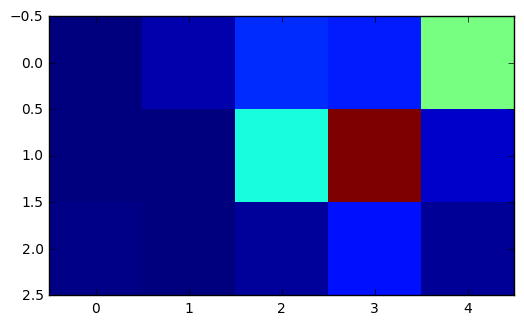

In [15]:
img_path = "./train/ALB/img_00110.jpg"
img = image.load_img(img_path)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

out = model.predict(x)

s = "n02512053"
ids = synset_to_dfs_ids(s)
heatmap = out[0,ids].sum(axis=0)
plt.imshow(heatmap, interpolation="none")
plt.show()

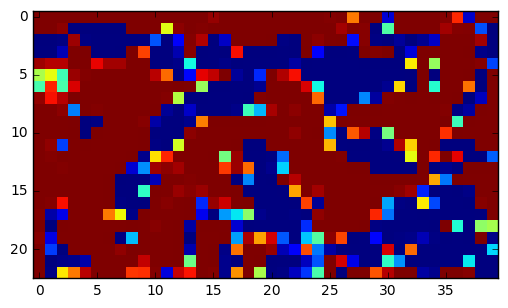

In [19]:
img_path = "./train/ALB/img_00003.jpg"
img = image.load_img(img_path)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

out = model.predict(x)

heatmap = out[0,[1]].sum(axis=0)
plt.imshow(heatmap, interpolation="none")
plt.show()

In [20]:
np.max(heatmap)

1.0

In [53]:
im = preprocess_image_batch(["./train/ALB/img_00110.jpg"], color_mode="bgr")

out = model.predict(im)

s = "n02512053"
ids = synset_to_dfs_ids(s)
heatmap = out[0,ids].sum(axis=0)

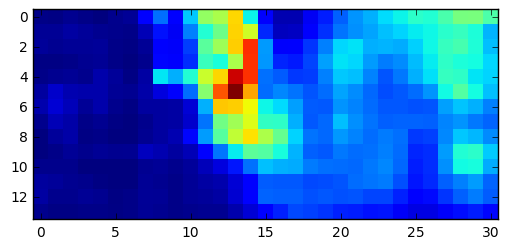

In [54]:
plt.imshow(heatmap, interpolation="none")
plt.show()

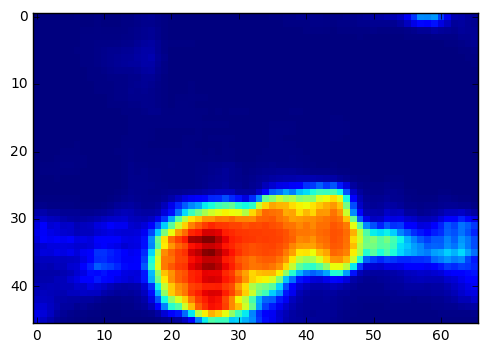

In [13]:
im = preprocess_image_batch(["./train/ALB/img_00136.jpg"], color_mode="bgr")

out = model.predict(im)

s = "n02512053"
ids = synset_to_dfs_ids(s)
heatmap = out[0,ids].sum(axis=0)
plt.imshow(heatmap, interpolation="none")
plt.show()

In [3]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_17 (ZeroPadding2D) (None, 3, None, None) 0           zeropadding2d_input_2[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, None, None 1792        zeropadding2d_17[0][0]           
____________________________________________________________________________________________________
zeropadding2d_18 (ZeroPadding2D) (None, 64, None, None 0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, None, None 36928       zeropadding2d_18[0][0]           
___________________________________________________________________________________________

In [27]:
my_weights = model.layers[-4].get_weights()

In [28]:
new = np.zeros(my_weights[0].shape[:-2] + (14,14))

In [29]:
new.shape

(4096, 512, 14, 14)

In [30]:
type(my_weights[0])

numpy.ndarray

In [32]:
c = tq(total=4096*512*14*14)
for i, j, k, l in itertools.product(range(new.shape[0]),range(new.shape[1]),range(new.shape[2]),range(new.shape[3])):
    if k%2 == 0 or l%2 == 0:
        new[i,j,k,l] = 0
    else:
        new[i,j,k,l] = my_weights[0][i,j, int((k-1)/2), int((l-1)/2)]
    c.update()
c.close()

Exception in thread Thread-44:
Traceback (most recent call last):
  File "C:\Program Files\Anaconda3\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Program Files\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Program Files\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [33]:
with open("big_matrix_2.p", "wb") as f:
    pickle.dump(new, f, pickle.HIGHEST_PROTOCOL)

In [9]:
#save_heatmaps(model,l,dest_pickle)

In [10]:
a = get_heatmap(l[0], model)

In [11]:
threshold = 0.3

def binarize(value, threshold):
    if value < threshold:
        return 0
    if value >= threshold:
        return 1
np_binarize = np.vectorize(binarize)

In [12]:
a

array([[ 0.00886695,  0.02040437,  0.05822657,  0.10496762,  0.10116637,
         0.09379505,  0.06448078,  0.06409685,  0.11049127,  0.15064456,
         0.12355788,  0.10550958,  0.1167753 ,  0.14981942,  0.12948784,
         0.13533321,  0.22252448,  0.37109506,  0.46473393,  0.40953663,
         0.43525839,  0.38892162,  0.39635763,  0.35841057,  0.30419993,
         0.20069076,  0.0978702 ,  0.07063601,  0.05721354,  0.07299374,
         0.07879868,  0.05065067,  0.03449849,  0.02222986],
       [ 0.08469439,  0.1153455 ,  0.16857667,  0.28859907,  0.17415766,
         0.14635539,  0.16356431,  0.20071074,  0.29608387,  0.25491056,
         0.14024435,  0.14790262,  0.2442413 ,  0.44574639,  0.42318425,
         0.31466362,  0.39450192,  0.48479295,  0.50225753,  0.48197499,
         0.39595655,  0.39389071,  0.53181678,  0.50252938,  0.35548547,
         0.22000548,  0.17814843,  0.12021383,  0.14606442,  0.15377185,
         0.10305704,  0.06337474,  0.03368217,  0.01393473],
  

In [13]:
b = np_binarize(a, threshold)

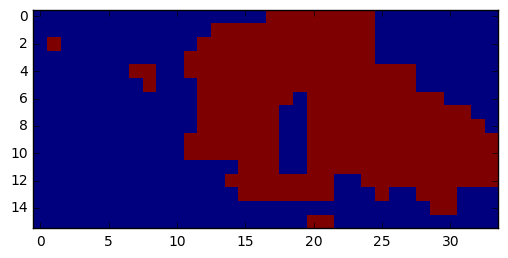

In [14]:
plt.imshow(b, interpolation='none')
plt.show()

In [15]:
def change_class(value, old, new):
    if value == old:
        return new
    else:
        return value
np_change_class = np.vectorize(change_class)




def stuff(mat,i,j,islands_list, count, islands_matrix):
    if mat[i][j] == 0:
        pass
    else:
        before = int(islands_matrix[i][j-1])
        above = int(islands_matrix[i-1][j])
        if before == 0:
            if  above== 0:
                islands_matrix[i][j] = count
                count +=1
                islands_list.append([(j,i)])
            else: 
                islands_matrix[i][j] = above
                islands_list[above-1].append((j,i))
        
        else:
            if above == 0:
                islands_matrix[i][j] = before
                islands_list[before-1].append((j,i))
            
            
            else:
                if above == before:
                    islands_matrix[i][j] = before
                    islands_list[before-1].append((j,i))
                
                #it's on.
                else:
                    old = max((above,before))
                    new = min((above,before))
                    
                    islands_matrix[i][j] = new
                    islands_matrix = np_change_class(islands_matrix, old, new)
                    islands_list[new-1] += islands_list[old-1]
                    islands_list[new-1].append((j,i))
                    islands_list[old-1] = []
                    
    return islands_list, count, islands_matrix        


# The not fun part
def group_by_island(matrix):
    
    h, l = np.shape(matrix)
    border = np.array([[0]*(l)])
    mat = np.concatenate((border,matrix), axis=0)
    border = np.array([[0]*(h+1)])
    mat = np.concatenate((border.T, mat), axis=1)
    
    islands_matrix =np.zeros((h+1,l+1))
    count = 1
    islands_list = []
    
    for i in range(1,h+1):
        for j in range(1, l+1):
            islands_list, count, islands_matrix = stuff(mat,i,j,islands_list, count, islands_matrix)

    
    
    return islands_matrix, islands_list
    

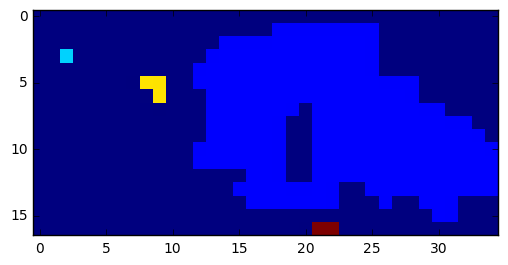

In [16]:
islands_matrix, islands_list = group_by_island(b)
plt.imshow(islands_matrix, interpolation='none')
plt.show()

In [17]:
def find_extremes(list_coordinates):
    max_x = max(list_coordinates, key = lambda x: x[0])[0]
    min_x = min(list_coordinates, key = lambda x: x[0])[0]
    max_y = max(list_coordinates, key = lambda x: x[1])[1]
    min_y = min(list_coordinates, key = lambda x: x[1])[1]
    
    #print(min_x, min_y, max_x, max_y )
    
    return min_x - 1, min_y - 1, max_x-min_x + 1, max_y-min_y + 1


def get_rectangles(islands_list, area_limit=4):
    list_coordinates = []
    for island in islands_list:
        if len(island) == 0:
            continue
        else:
            coordinates = find_extremes(island)
            #print(coordinates)
            #print(coordinates[2]*coordinates[3])
            if coordinates[2]*coordinates[3] >=area_limit:
                #print(coordinates)
                list_coordinates.append(coordinates)
            
    return list_coordinates
    

In [18]:
rectangles = get_rectangles(islands_list)

In [19]:
print(rectangles[0])

(11, 0, 23, 15)


In [20]:
def convert_coordinates(rectangles, heatmap, path_image):
    y, x = np.shape(heatmap)
    #print('y=' + str(y))
    #print("x=" + str(x))
    
    img = np.array(Image.open(path_image))
    y1, x1, channel = np.shape(img)
    #print("x1=" + str(x1))
    #print("y1=" + str(y1))
    
    ratio_x = x1/x
    ratio_y = y1/y
    
    converted_rectangles = []
    for r in rectangles:
        converted_rectangles.append((r[0]*ratio_x, r[1]*ratio_y, r[2]*ratio_x, r[3]*ratio_y,))
        
    return converted_rectangles

In [21]:
new_rectangles = convert_coordinates(rectangles, a, l[0])

In [22]:
new_dic = {"filename": l[0], "rectangles": new_rectangles}

In [23]:
new_dic

{'filename': './train/ALB\\img_00003.jpg',
 'rectangles': [(414.11764705882354, 0.0, 865.8823529411765, 675.0),
  (263.5294117647059, 180.0, 75.29411764705883, 90.0)]}

In [25]:
c=0.4
def from_pickle_to_rectangle(img_path, pickle_path):
    
    with open(pickle_path,"rb") as f:
        heatmap = pickle.load(f)
        
    # Here we will modify the heatmap, removing activation on the extremes of the image, because
    # cause the fish detector to activate too often for some reason.
    line_zeros = np.zeros(np.shape(heatmap)[0])
    column_zeros = np.zeros(np.shape(heatmap)[1])
    heatmap[:,0] = line_zeros
    heatmap[:,-1] = line_zeros
    heatmap[0,] = column_zeros
    heatmap[-1,:] = column_zeros
    
        
    #print(np.shape(heatmap))
    threshold = c*np.max(heatmap)
    binary_map = np_binarize(heatmap, threshold)
    islands_matrix, islands_list = group_by_island(binary_map)
    rectangles = get_rectangles(islands_list, area_limit=4)
    #print(rectangles[0])
    new_rectangles = convert_coordinates(rectangles, heatmap, img_path)
    #print(new_rectangles[0])
    new_dic = {"path": img_path, "rectangles": new_rectangles, "p_fish": np.max(heatmap)}
    
    
    return new_dic

In [26]:
list_rectangles_images = []
for i in tq(range(len(l))):
    dic = from_pickle_to_rectangle(l[i], dest_pickle[i])
    list_rectangles_images.append(dic)

In [25]:
import os
from fnmatch import fnmatch

l = []

root = './test_stg1/'
pattern = "*.jpg"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            l.append(os.path.join(path, name))

In [26]:
l[0]

'./test_stg1/img_00005.jpg'

In [27]:
s = 11
dest = [ string[:s] + "_heatmap" + string[s:] for string in l]
dest[0]

'./test_stg1_heatmap/img_00005.jpg'

In [28]:
dest_pickle = [string[:s] + "_pickle" + string[s:] for string in l]

In [29]:
#save_heatmaps(model,l,dest_pickle, dest)

In [42]:
list_rectangles_images = []
for i in tq(range(len(l))):
    dic = from_pickle_to_rectangle(l[i], dest_pickle[i])
    list_rectangles_images.append(dic)

In [31]:
with open("test_rectangles.p", "wb") as f:
    pickle.dump(list_rectangles_images,f)

In [34]:
my_list[0:5]

[{'p_fish': 0.75145096, 'path': './test_stg1/img_00005.jpg', 'rectangles': []},
 {'p_fish': 0.86994344,
  'path': './test_stg1/img_00007.jpg',
  'rectangles': [(675.0, 0.0, 675.0, 451.7647058823529)]},
 {'p_fish': 0.96823865,
  'path': './test_stg1/img_00009.jpg',
  'rectangles': [(360.0, 0.0, 1080.0, 263.5294117647059)]},
 {'p_fish': 0.77316874,
  'path': './test_stg1/img_00018.jpg',
  'rectangles': [(630.0, 0.0, 810.0, 338.8235294117647)]},
 {'p_fish': 0.56881583,
  'path': './test_stg1/img_00027.jpg',
  'rectangles': [(495.0, 301.1764705882353, 135.0, 112.94117647058823)]}]

In [ ]:
for i in range(50,70):
    dic = list_rectangles_images[i]
    img = Image.open(dic["path"])
    print(str(dic["p_fish"]*100) + "        " + dic["path"])
    plt.imshow(img)
    plt.show()
    
    with open(dest_pickle[i], "rb") as f:
        heatmap = pickle.load(f)
        
    
    line_zeros = np.zeros(np.shape(heatmap)[0])
    column_zeros = np.zeros(np.shape(heatmap)[1])
    heatmap[:,0] = line_zeros
    heatmap[:,-1] = line_zeros
    heatmap[0,] = column_zeros
    heatmap[-1,:] = column_zeros
        
    plt.imshow(heatmap, interpolation='none')
    plt.show()
    
    threshold = c*np.max(heatmap)
    binary_map = np_binarize(heatmap, threshold)
    
    plt.imshow(binary_map, interpolation='none')
    plt.show()
    
    for rec in dic["rectangles"]:
        print("fish found: " + str(rec))
        img2 = img.crop((rec[0],rec[1], rec[0] + rec[2], rec[1] + rec[3]))
        plt.imshow(img2)
        plt.show()

In [99]:
def get_sea_rectangle(predict):
    
    
    
    # We make the assumpption that the standart image size is 57x101
    # the order is x top left, y top left, x bottom right, y bottom right
    # This is the string order, not the numerical order! beware!
    if predict ==1:
        rectangle = [[58,0,100,56]]
    if predict ==10:
        rectangle = [[0,45,15,56]]
    if predict ==11:
        rectangle = [[80,0,100,56],[0,0,20,20]]
    if predict ==12:
        rectangle = [[0,0,20,56]]
    if predict ==13:
        rectangle = [[0,30,100,56]]
    if predict ==14:
        rectangle = [[85,0,100,56],[0,40,30,56]]
    if predict ==15:
        rectangle = [[0,0,100,15],[0,0,30,30]]
    if predict ==16:
        rectangle = [[0,0,10,56]]
    if predict ==17:
        rectangle = [[55,0,100,56]]
    if predict ==2:
        rectangle = [[50,0,100,56]]
    if predict ==3:
        rectangle = [[0,0,25,56]]
    if predict ==4:
        rectangle = [[0,0,100,15]]
    if predict ==5:
        rectangle = [[0,0,100,20],[65,0,100,56]]
    if predict ==6:
        rectangle = [[0,0,100,25],[0,0,20,56]]
    if predict ==7:
        rectangle = [[0,0,20,56],[75,0,100,20]]
    if predict ==8:
        rectangle = [[0,0,20,56]]
    if predict ==9:
        rectangle = [[80,0,100,56]]
    return rectangle
    

In [100]:
del model

In [101]:
model = load_model("cool_model_boats_id.h5")

In [102]:
def remove_patches(heatmap, rectangles):
    y_map, x_map = np.shape(heatmap)
    for rectangle in rectangles: 
        x_min = int(rectangle[0] *x_map/100)
        x_max = int(rectangle[2] *x_map/100)
        y_min = int(rectangle[1] *y_map/56)
        y_max = int(rectangle[3] *y_map/56)
        
        for i in range(y_map):
            for j in range(x_map):
                if y_min<=i<y_max and x_min<=j<x_max:
                    heatmap[i,j] = 0
                    
    return heatmap

In [112]:
def hide_sea(heatmap, img_path, treashold = 0.87):
    img = load_img(img_path,grayscale=True, target_size=(64,64))
    img = img_to_array(img)
    
    probabilities = model.predict(np.array([img,]))[0][1:]
    #print(probabilities)
    
    if np.max(probabilities) >= treashold:
        rectangles = get_sea_rectangle(np.argmax(probabilities) + 1)
        heatmap = remove_patches(heatmap, rectangles)
    
    return heatmap

In [113]:
c=0.4
def from_pickle_to_rectangle(img_path, pickle_path, plot=False):
    
    with open(pickle_path,"rb") as f:
        heatmap = pickle.load(f)
        
    # Here we will modify the heatmap, removing activation on the extremes of the image, because
    # cause the fish detector to activate too often for some reason.
    line_zeros = np.zeros(np.shape(heatmap)[0])
    column_zeros = np.zeros(np.shape(heatmap)[1])
    heatmap[:,0] = line_zeros
    heatmap[:,-1] = line_zeros
    heatmap[0,] = column_zeros
    heatmap[-1,:] = column_zeros
    
    if plot:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        plt.imshow(heatmap, interpolation='none')
        plt.show()
    
    heatmap = hide_sea(heatmap, img_path)
    
    if plot:
        plt.imshow(heatmap, interpolation='none')
        plt.show()
        
    #print(np.shape(heatmap))
    threshold = c*np.max(heatmap)
    binary_map = np_binarize(heatmap, threshold)
    
    if plot:
        plt.imshow(binary_map, interpolation='none')
        plt.show()
    
    islands_matrix, islands_list = group_by_island(binary_map)
    rectangles = get_rectangles(islands_list, area_limit=4)
    new_rectangles = convert_coordinates(rectangles, heatmap, img_path)
    new_dic = {"path": img_path, "rectangles": new_rectangles, "p_fish": np.max(heatmap)}
    
    if plot:
        for rec in new_dic["rectangles"]:
            print("fish found: " + str(rec))
            img2 = img.crop((rec[0],rec[1], rec[0] + rec[2], rec[1] + rec[3]))
            plt.imshow(img2)
            plt.show()
    
    return new_dic

In [ ]:
list_rectangles_images = []
for i in tq(range(50,70)):
    dic = from_pickle_to_rectangle(l[i], dest_pickle[i], True)
    list_rectangles_images.append(dic)